In [1]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

import calendar
import datetime as dt
from itertools import chain
from datetime import datetime, timedelta
import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import seaborn as sns
from scipy import stats

In [2]:
# -- STORE ALL FITBIT DATA INTO LISTS OF SHEET --
xls_files = glob.glob('Fitbit/*.xls')

## Functions

In [3]:
def add_weekday(df, not_index=0):
    """Add day of week column"""
    
    # -- USE DATAFRAME'S INDEX IF 'not_index' = 1, OTHERWISE USE DATAFRAME'S 'Date' COLUMN --
    col = df.index
    if not_index:
        col = df['Date']
    
    # -- DETERMINE THE DAY OF WEEK FROM THE DATE AND STORE IN A LIST (USED TO ADD AS A COLUMN TO THE DATAFRAME) --
    weekday = []
    for date in col:
        #weekday.append(datetime.strptime(str(date), '%Y-%m-%d').strftime('%A'))
        weekday.append(calendar.day_name[date.weekday()])
    df.loc[:, 'Weekday'] = weekday
    
    
def to_num(df, list_of_cols):
    """Remove commas and convert values to a numeric data type"""
    
    for col in list_of_cols:
        #df[col] = df[col].str.replace(',', '')
        df[col] = df[col].str.replace('\D', '', regex=True)
        df[col] = pd.to_numeric(df[col])
        

def to_date(df, list_of_col):
    """Convert columns into datetime type"""
    
    for col in list_of_col:
        df[col] = pd.to_datetime(df[col])
        
        
def replace_outliers(df):
    """Replace outliers with mean"""
    
    for col in df.columns:
        mean = df[col].mean()
        std = df[col].std()
        df[col] = df[col].mask(((df[col] - mean).abs() > 2 * std), mean)

### Function for wrangling sleep data

In [4]:
def sort_sleep_data(list_of_df):
    """Sort sleep data by date"""
    
    for i in range(len(list_of_df)):
        list_of_df[i].sort_values(by='Start Time', ascending=True, inplace=True)

### Functions for wrangling food and macros data

In [5]:
def flatten_list(l):
    """Flatten a list"""
    
    return list(chain(*l))


def get_sheetnames_and_dates(excel_file):
    """Only get sheet names and dates for days where food data is entered"""
    """Returns: 2 lists (sheet names & dates)"""
    
    monthly_calories = pd.ExcelFile(excel_file).parse('Foods')

    dates = []
    sheet_names = []
    
    # -- GET SHEET NAMES AND DATES ONLY FOR THE DAYS WHERE INFO ABOUT FOOD INTAKE IS ENTERED --
        # -- daily[0]: date --
        # -- daily[1]: calories --
    for daily in monthly_calories.values:
        if str(daily[1]) != '0':
            dates.append(datetime.strptime(daily[0], '%Y-%m-%d').date())
            foodLogSheetName = 'Food Log ' + daily[0].replace('-', '')
            sheet_names.append(foodLogSheetName)
    return sheet_names, dates


def remove_empty_rows(xls, sheet_list):
    """Converting data in labeled table format to dataframe format"""
    """Returns: dataframe without unnecessary data"""
    
    df_list = [pd.read_excel(xls, sheet_name=sheet) for sheet in sheet_list]

    # -- REMOVING UNNECESSARY ROWS & FILLING IN 'MISSING' DATA --
    for df in df_list:
        df.dropna(how='all', inplace=True)
        df['Meal'] = df['Meal'].fillna(method='ffill')
        df.reset_index(drop=True, inplace=True)
        
    return df_list


def get_food_and_macros(food_list, dates_list):
    """Get macros information into desirable dataset format"""
    """Returns: 2 dataframes (one with food consumption data & one with daily macros info)"""

    macros_df = pd.DataFrame()
    all_food_df = pd.DataFrame()
    all_macros_df = pd.DataFrame()
    
    # -- SPLITTING DATA INTO TWO DIFFERENT DATAFRAMES --
    for ind, (df, date) in enumerate(zip(food_list, dates_list)):
        
        index_of_macros = []

        # -- STORE INDEX OF ROWS THAT HAVE MACROS DATA --
        for i in df.index:
            if df['Meal'][i] == 'Daily Totals':
                index_of_macros.append(i)

        # -- EXTRACT MACROS DATA FROM THE DATAFRAME. CREATE & STORE MACROS DATA IN A NEW DATAFRAME --
        macros_df = df.iloc[index_of_macros[1]:index_of_macros[-1]+1]
        macros_df['Date'] = date
        macros_df = macros_df.pivot(index='Date', columns='Food', values='Calories')
        all_macros_df = all_macros_df.append(macros_df)

        # -- ADD 'Date' COLUMN TO THE FOOD DATAFRAME --
        food_list[ind]['Date'] = date

        # -- STORE EACH UPDATED FOOD DATAFRAME INTO A NEW DATAFRAME --
        all_food_df = all_food_df.append(food_list[ind].drop(index=index_of_macros).dropna())

    return all_food_df, all_macros_df

## Data wrangling

### Cleaning activities & sleep data

In [6]:
# -- STORING DATA IN EXCEL AS LISTS DATAFRAMES --
list_of_activities_df = [pd.ExcelFile(xls).parse('Activities', index_col=0, parse_dates=True) for xls in xls_files]
list_of_sleep_df = [pd.ExcelFile(xls).parse('Sleep', usecols=':F') for xls in xls_files]

# -- CONCATING ALL FOOD DATAFRAMES INTO ONE BIG DATAFRAME --
activities = pd.concat(list_of_activities_df)

# -- CONCATING ALL SLEEP DATAFRAMES INTO ONE BIG DATAFRAME --
sort_sleep_data(list_of_sleep_df)
sleep = pd.concat(list_of_sleep_df)
sleep.reset_index(drop=True, inplace=True)

# -- GET COLUMNS TO CORRECT TYPE & REMOVING MISSING VALUES --
to_num(activities, ['Calories Burned', 'Steps', 'Minutes Sedentary', 'Activity Calories'])
to_date(sleep, ['Start Time', 'End Time'])
activities = activities[activities['Steps'] != 0]

# -- CREATE A NEW SLEEP DATAFRAME WHERE THERE WILL ONLY BE ONE RECORD FOR EACH DAY --
dates = []
for i in range(len(sleep['Start Time'])):
    date = sleep['Start Time'][i].date()
    time = sleep['Start Time'][i].time()
    # -- BEDTIMES BEFORE 4AM ARE CONSIDERED TO BE PREVIOUS DAY'S SLEEP --
    if time > dt.time(4):
        dates.append(date)
    else:
        dates.append(date - timedelta(1))
sleep['Date'] = dates

daily_sleep = sleep.groupby('Date').sum()
daily_sleep.index = pd.to_datetime(daily_sleep.index)

# -- CREATE ANOTHER SLEEP DATAFRAME WITH NO NAP ENTRIES --
for x in sleep['Start Time']:
    x = x.to_pydatetime()

indices = []
for i, x in enumerate(sleep['Start Time']):
    if (x.time() > dt.time(20)) | (x.time() < dt.time(4)):
        indices.append(i)
        
sleep_night = sleep.loc[indices]
sleep_night = sleep_night.groupby('Date').sum()

# -- REPLACE OUTLIERS WITH MEAN --
replace_outliers(activities)
replace_outliers(daily_sleep)

# -- ADD DAY OF WEEK COLUMN --
add_weekday(activities)
add_weekday(daily_sleep)

### Cleaning food data

In [7]:
# -- GET ALL NECESSARY SHEET NAMES AND DATES --
sheet_names, dates = zip(*[get_sheetnames_and_dates(xls) for xls in xls_files])
dates = [d for d in dates if d]

# -- FIRST STEP IN DATA CLEANING: REMOVING ALL EMPTY ROWS --
list_of_food_df = [remove_empty_rows(xls, monthly_sheets) for xls, monthly_sheets in zip(xls_files, sheet_names) if monthly_sheets]

# -- SECOND STEP IN DATA CLEANING: SPLIT ORIGINAL DATAFRAMES INTO SEPARATE DATAFRAMES --
list_of_food_df, list_of_macros_df = zip(*[get_food_and_macros(monthly_food, date) for monthly_food, date in zip(list_of_food_df, dates)])

macros = pd.concat(list_of_macros_df)
food = pd.concat(list_of_food_df)
food.reset_index(drop=True, inplace=True)

to_num(macros, ['Calories', 'Carbs', 'Fat', 'Fiber', 'Protein', 'Sodium', 'Water'])

add_weekday(macros)
add_weekday(food, 1)

macros.columns = ['Calories (g)', 'Carbs (g)', 'Fat (g)', 'Fiber (g)', 'Protein (g)', 'Sodium (mg)', 'Water (fl oz)', 'Weekday']

In [8]:
sns.set()

## Machine Learning

In [9]:
# -- CREATING HEART RATE DATAFRAME --
hr_files = glob.glob('FitbitHR/*.csv')
list_of_heartrate_df = [pd.read_csv(file) for file in hr_files]

# -- GET DATA FROM FILE NAME --
list_of_dates = [re.search('FitbitHR/(\d{4}-\d{2}-\d{2}).csv', file).group(1) for file in hr_files]

# -- CREATE 'Date' COLUMN WITH list_of_dates --
for i, df in enumerate(list_of_heartrate_df):
    df['Date'] = list_of_dates[i]

heartrate_df = pd.concat(list_of_heartrate_df)
heartrate_df.Time = pd.to_datetime(heartrate_df['Time']).dt.time

### Supervised Learning -- Predicting Calories Burned with Sum of Heart Rates per Day

In [10]:
# -- CHANGING DATE TYPE OF COLUMNS --
to_date(heartrate_df, ['Date'])
heartrate_df['Date'] = heartrate_df['Date'].dt.date

activities.index = activities.index.date
daily_sleep.index = daily_sleep.index.date


# -- GROUP HEART RATE DATA BY DAY --
hr_daily_sum = heartrate_df.groupby('Date').sum()#.to_frame().reset_index()

for i in range(len(hr_daily_sum)):
    index_value = hr_daily_sum.index[i]
    hr_daily_sum.loc[index_value, 'Calories Burned'] = int(activities.loc[index_value]['Calories Burned'])
    
hr_daily_sum.head()

,Heart Rate,Calories Burned
Date,,
2017-02-22,96265,2474.0
2017-02-23,100505,2963.0
2017-02-24,93022,2449.0
2017-02-25,94511,2649.0
2017-02-26,93240,2640.0


In [11]:
from sklearn import linear_model, metrics
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score

# -- SPLIT TO TEST AND TRAINING SET --
X_train, X_test, y_train, y_test = train_test_split(hr_daily_sum['Heart Rate'].values.reshape(-1,1), hr_daily_sum['Calories Burned'].values.reshape(-1,1), test_size = 0.3, random_state = 42)

# -- LINEAR REGRESSION --
reg = linear_model.LinearRegression()
reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)

print('LINEAR REGRESSION')
print('-----------------')
print('Mean absolute error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)), '\n')

# -- CROSS VALIDATION --
cv_results = cross_val_score(reg, hr_daily_sum['Heart Rate'].values.reshape(-1,1), hr_daily_sum['Calories Burned'].values.reshape(-1,1), cv = 5)
print('Cross validation results:', cv_results, '\n\n')


# -- RANDOM FOREST REGRESSOR --
forest = RandomForestRegressor(100)
forest.fit(X_train, y_train)
y_pred = forest.predict(X_test)

print('RANDOM FOREST REGRESSOR')
print('-----------------------')
print('Mean absolute error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)), '\n')

# -- CROSS VALIDATION --
cv_results = cross_val_score(forest, hr_daily_sum['Heart Rate'].values.reshape(-1,1), hr_daily_sum['Calories Burned'].values.reshape(-1,1), cv = 5)
print('Cross validation results:', cv_results)

LINEAR REGRESSION
-----------------
Mean absolute error: 234.7799212462273
Mean error: 297.1541601692999 

Cross validation results: [0.33977675 0.45372836 0.53440749 0.52467865 0.04831244] 


RANDOM FOREST REGRESSOR
-----------------------
Mean absolute error: 234.99395161290323
Mean error: 308.6052533257364 

Cross validation results: [-0.1871205   0.37696658  0.42310368  0.50403895  0.24006372]


Looking at both mean absolute error and mean error, the Linear Regression and Random Forest Regressor models have similar performance. Looking at the cross validation scores though, I sm inclined to believe Linear Regression is the better model for the data. However, both models, on average, will make an average error of 200+ calories. Both models underfit the training data. What can be done is to add more features or use more powerful models. However, it is important to once again note that Tracy is in fact a group exercise instructor who has a busy teaching schedule to follow. There certain times of certain days where she will be working out, and all other activity data are dependent on how active minutes. This creates limitations in building strong models. 

### Heart rate data by times of day (morning, afternoon, evening)

In [12]:
# -- ONE MINUTE UNTIL THE END OF EACH TIME OF DAY --
MORNING = dt.time(11, 59)
AFTERNOON = dt.time(17, 59)
EVENING = dt.time(23, 59)

# -- CREATING 'Time_of_Day' COLUMN --
heartrate_df.loc[heartrate_df.Time <= MORNING, 'Time_of_Day'] = 'Morning'
heartrate_df.loc[(heartrate_df.Time > MORNING) & (heartrate_df.Time <= AFTERNOON), 'Time_of_Day'] = 'Afternoon'
heartrate_df.loc[(heartrate_df.Time > AFTERNOON) & (heartrate_df.Time <= EVENING), 'Time_of_Day'] = 'Evening'

# -- CREATING NEW DATAFRAME TO WORK WITH --
tod = heartrate_df.groupby(['Date', 'Time_of_Day'], sort=False).mean()
df2 = pd.merge(tod, activities[['Calories Burned']], left_on = 'Date', right_index = True)
df2 = df2.rename_axis(['Date', 'Time of Day']).reset_index()
df2.head()

,Date,Time of Day,Heart Rate,Calories Burned
0,2017-02-22,Morning,69.084388,2474.0
1,2017-02-22,Afternoon,67.763889,2474.0
2,2017-02-22,Evening,63.197222,2474.0
3,2017-02-23,Morning,72.344633,2963.0
4,2017-02-23,Afternoon,78.405556,2963.0


In [13]:
# -- SPLIT INTO THREE DIFFERENT DATAFRAMES, BY TIME OF DAY --
morning, afternoon, evening = df2.groupby('Time of Day')

morning = morning[1]
afternoon = afternoon[1]
evening = evening[1]

# -- CREATING THE TRAIN AND TEST SETS --
X_train1, X_test1, y_train1, y_test1 = train_test_split(morning.drop(['Date', 'Time of Day', 'Calories Burned'], \
                                                        axis = 1).values, morning['Calories Burned']\
                                                        .values.reshape(-1,1), test_size = 0.3, random_state = 42)
X_train2, X_test2, y_train2, y_test2 = train_test_split(afternoon.drop(['Date', 'Time of Day', 'Calories Burned'], \
                                                        axis = 1).values, morning['Calories Burned']\
                                                        .values.reshape(-1,1), test_size = 0.3, random_state = 42)
X_train3, X_test3, y_train3, y_test3 = train_test_split(evening.drop(['Date', 'Time of Day', 'Calories Burned'], \
                                                        axis = 1).values, morning['Calories Burned']\
                                                        .values.reshape(-1,1), test_size = 0.3, random_state = 42)

# -- FITTING AND PREDICTING RANDOM FOREST REGRESSOR MODELS --
forest1 = RandomForestRegressor()
forest2 = RandomForestRegressor()
forest3 = RandomForestRegressor()

forest1.fit(X_train1, y_train1)
forest2.fit(X_train2, y_train2)
forest3.fit(X_train3, y_train3)

y_pred1 = forest1.predict(X_test1)
y_pred2 = forest2.predict(X_test2)
y_pred3 = forest3.predict(X_test3)

print('MORNING')
print('-------')
print('Mean absolute error:', metrics.mean_absolute_error(y_test1, y_pred1))
print('Mean error:', np.sqrt(metrics.mean_squared_error(y_test1, y_pred1)), '\n')

print('AFTERNOON')
print('---------')
print('Mean absolute error:', metrics.mean_absolute_error(y_test2, y_pred2))
print('Mean error:', np.sqrt(metrics.mean_squared_error(y_test2, y_pred2)), '\n')

print('EVENING')
print('-------')
print('Mean absolute error:', metrics.mean_absolute_error(y_test3, y_pred3))
print('Mean error:', np.sqrt(metrics.mean_squared_error(y_test3, y_pred3)))

MORNING
-------
Mean absolute error: 305.3061048459947
Mean error: 386.06772796675557 

AFTERNOON
---------
Mean absolute error: 366.54289710639046
Mean error: 460.4743051951462 

EVENING
-------
Mean absolute error: 248.93655768278114
Mean error: 312.9841920188726


Using the average heart rate by time of day to estimate calories burned, we get the above results for each model. Regardless of time of day, neither of the three average heart rates seem to be good predictors for the amount of calories burned for the day. The smallest prediction error of the three models is off by at least 230 calories, which is quite substantial--it would take 15-20 minutes of jump roping to burn off about 200 calories. This suggests all models are underfitting. Looking at heart rate separately by time of day does not create a better predictive model. More features might be necessary to improve the models.

In [14]:
# -- CREATING ANOTHER DATAFRAME WITH AVERAGE HEART RATE BY DAY AS FEATURES --
df3 = pd.pivot_table(tod, index='Date', columns=['Time_of_Day']).merge(activities[['Calories Burned']], \
                                                                       left_on = 'Date', right_index = True)
df3.head()

,"(Heart Rate, Afternoon)","(Heart Rate, Evening)","(Heart Rate, Morning)",Calories Burned
Date,,,,
2017-02-22,67.763889,63.197222,69.084388,2474.0
2017-02-23,78.405556,58.660167,72.344633,2963.0
2017-02-24,70.273239,61.425714,69.206538,2449.0
2017-02-25,71.941341,60.113889,69.388807,2649.0
2017-02-26,69.534483,60.157233,69.322222,2640.0


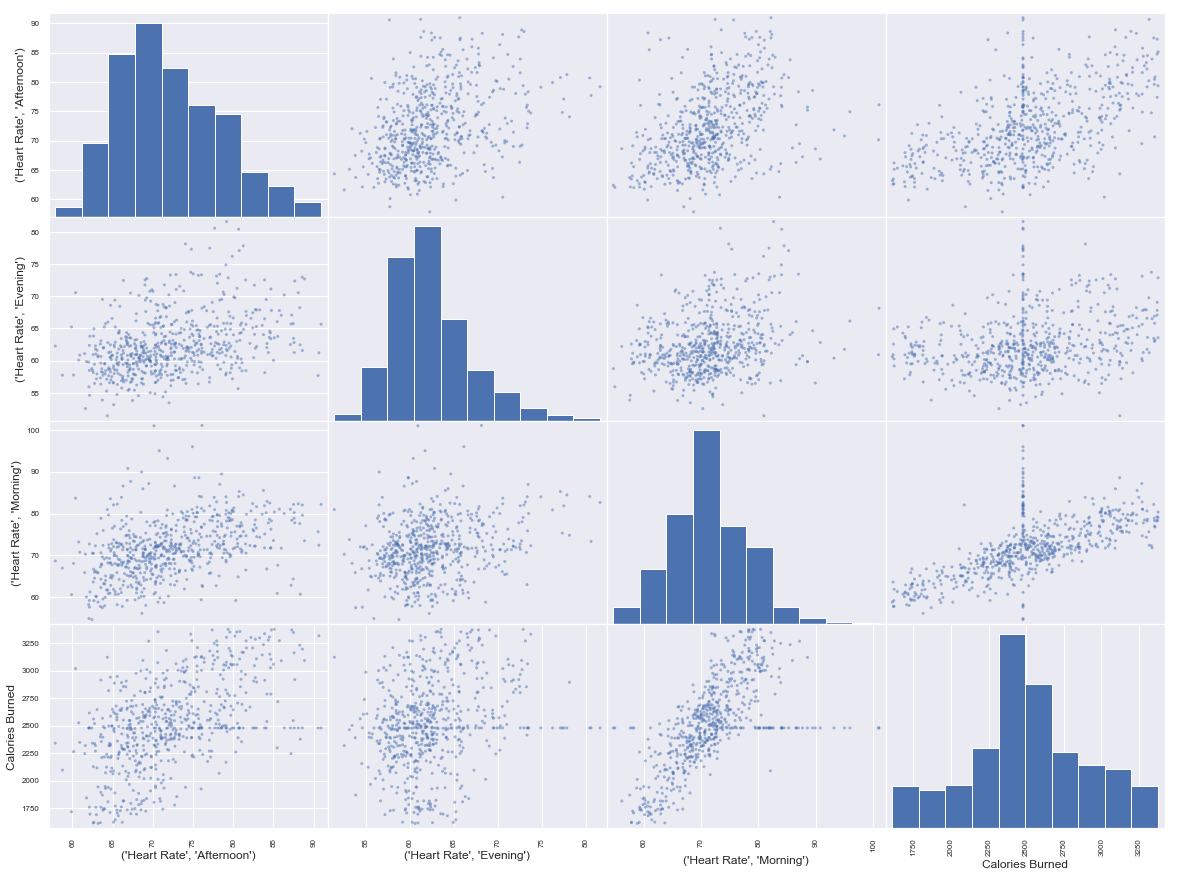

In [15]:
from pandas.tools.plotting import scatter_matrix

scatter_matrix(df3, figsize=(20,15))
plt.show()

In [16]:
corr_matrix = df3.corr()
corr_matrix['Calories Burned'].sort_values(ascending=False)

Calories Burned            1.000000
(Heart Rate, Morning)      0.668152
(Heart Rate, Afternoon)    0.537112
(Heart Rate, Evening)      0.241254
Name: Calories Burned, dtype: float64

Based on the correlation and scatter matrices above, there are no two features that have an extremely strong correlation with each other. The feature most correlated with 'Calories Burned' is 'Heart Rate, Morning'.

In [17]:
X_train, X_test, y_train, y_test = train_test_split(df3.drop('Calories Burned', axis = 1).values, \
                                                    df3['Calories Burned'].values.reshape(-1,1), \
                                                    test_size = 0.3, random_state = 42)

reg = linear_model.LinearRegression()
reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)

print('LINEAR REGRESSION')
print('-----------------')
print('Mean absolute error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)), '\n')

cv_results = cross_val_score(reg, df3.drop('Calories Burned', axis=1), \
                             df3['Calories Burned'].values.reshape(-1,1), cv=5)
print('Cross validation results:', cv_results, '\n')

model = RandomForestRegressor()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print('RANDOM FOREST REGRESSOR')
print('-----------------------')
print('Mean absolute error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)), '\n')

cv_results = cross_val_score(model, df3.drop('Calories Burned', axis=1), \
                             df3['Calories Burned'].values.reshape(-1,1), cv=5)
print('Cross validation results:', cv_results)

LINEAR REGRESSION
-----------------
Mean absolute error: 212.88384694797185
Mean error: 265.31942766617124 

Cross validation results: [ 0.1959427   0.46651428  0.66728062  0.5962532  -0.09702459] 

RANDOM FOREST REGRESSOR
-----------------------
Mean absolute error: 188.15398053442902
Mean error: 233.95492215777713 

Cross validation results: [0.21542131 0.54087648 0.73951225 0.66745632 0.34743601]


Indeed, restructuring the dataframe by having average heart rate by time of day as features creates a better model (compared to predicting calories burned by sum of heart rates per day)! The mean absolute error is now under 200 calories.

### Unsupervised Learning

Text(0,0.5,'Inertias')

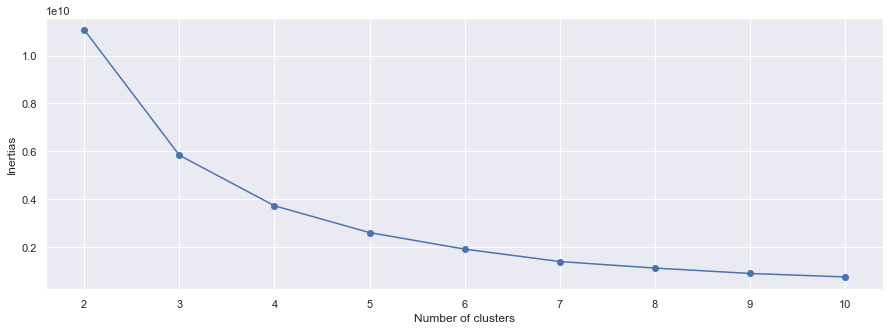

In [18]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

x_cols = np.array(hr_daily_sum.reset_index(drop=True))

# -- CHOOSING K --
ks = np.arange(2,11)
inertias = []
for k in ks:
    model = KMeans(n_clusters = k, random_state = 42)
    model.fit(x_cols)
    inertias.append(model.inertia_)

plt.figure(figsize=(15,5))
plt.plot(ks, inertias, '-o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertias')

Text(0.5,1,'Plot for K = 3')

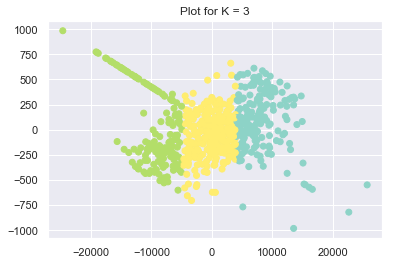

In [19]:
k = KMeans(n_clusters = 3, random_state = 42)
hr_daily_sum['cluster'] = k.fit(x_cols).labels_

model = PCA(n_components = 2)
transformed = model.fit_transform(x_cols)
hr_daily_sum['x'] = transformed[:,0]
hr_daily_sum['y'] = transformed[:,1]

plt.scatter('x', 'y', c = 'cluster', cmap='Set3', data = hr_daily_sum)
plt.title('Plot for K = 3')

In [20]:
hr_daily_sum.head()

,Heart Rate,Calories Burned,cluster,x,y
Date,,,,,
2017-02-22,96265,2474.0,2,1842.147570,-23.428156
2017-02-23,100505,2963.0,2,-2413.444787,-350.008460
2017-02-24,93022,2449.0,0,5083.733345,-122.401200
2017-02-25,94511,2649.0,2,3588.176962,-265.342113
2017-02-26,93240,2640.0,0,4858.592195,-304.929177


In [21]:
# -- AVOID MERGING DUPLICATE COLUMNS --
cols_to_use = activities.columns.difference(hr_daily_sum.columns)

# -- MERGING hr_daily_sum, activities, and sleep_night DATAFRAMES --
df = pd.merge(hr_daily_sum, activities[cols_to_use], left_index=True, right_index=True).drop(['x', 'y'], axis = 1)
df = pd.merge(df, sleep_night, left_index=True, right_index=True)

df['is 0'] = df['cluster'] == 0
df['is 1'] = df['cluster'] == 1
df['is 2'] = df['cluster'] == 2

df.head()

,Heart Rate,Calories Burned,cluster,Activity Calories,Distance,Floors,Minutes Fairly Active,Minutes Lightly Active,Minutes Sedentary,Minutes Very Active,Steps,Weekday,Minutes Asleep,Minutes Awake,Number of Awakenings,Time in Bed,is 0,is 1,is 2
2017-02-22,96265,2474.0,2,1561.0,8.92,18.0,11.0,310.0,NaN,79.0,20326.0,Wednesday,479,18,0,497,False,False,True
2017-02-23,100505,2963.0,2,2214.0,11.74,29.0,68.0,393.0,NaN,127.0,28255.0,Thursday,415,6,1,422,False,False,True
2017-02-24,93022,2449.0,0,1574.0,7.31,28.0,36.0,414.0,NaN,34.0,18335.0,Friday,506,27,1,533,True,False,False
2017-02-25,94511,2649.0,2,1780.0,8.54,20.0,44.0,283.0,NaN,110.0,20452.0,Saturday,515,29,2,544,False,False,True
2017-02-26,93240,2640.0,0,1759.0,10.21,22.0,16.0,336.0,NaN,75.0,22848.0,Sunday,455,18,2,473,True,False,False


In [22]:
print('CLUSTER 0:')
print(df[df['is 0']].Weekday.value_counts(), '\n')
print('CLUSTER 1:')
print(df[df['is 1']].Weekday.value_counts(), '\n')
print('CLUSTER 2:')
print(df[df['is 2']].Weekday.value_counts())

CLUSTER 0:
Sunday       72
Friday       35
Saturday     30
Thursday     15
Tuesday      12
Wednesday     7
Monday        5
Name: Weekday, dtype: int64 

CLUSTER 1:
Monday       51
Wednesday    46
Saturday     22
Tuesday      14
Friday        7
Thursday      6
Sunday        2
Name: Weekday, dtype: int64 

CLUSTER 2:
Thursday     63
Tuesday      62
Friday       36
Saturday     34
Wednesday    34
Monday       30
Sunday       13
Name: Weekday, dtype: int64


Based on KMeans, it was determined that 3 clusters yields optimal results. By examining each of the three clusters, it seems that day of week is deterministic of how the clusterings are formed. **Cluster 0** contains mostly Sunday's, **Cluster 1** contains Monday's and Wednesday's, and **Cluster 2** contains Tuesday's and Thursday's. Saturday's don't have a prominent presence in any of the clusters, but do appear most in Cluster 0 and 2.

In [23]:
print('\nMINUTES SEDENTARY')
print('-----------------')
print('Cluster 0:', df[df['is 0']]['Minutes Sedentary'].mean())
print('Cluster 1:', df[df['is 1']]['Minutes Sedentary'].mean())
print('Cluster 2:', df[df['is 2']]['Minutes Sedentary'].mean())

print('\nMINUTES LIGHTLY ACTIVE')
print('----------------------')
print('Cluster 0:', df[df['is 0']]['Minutes Lightly Active'].mean())
print('Cluster 1:', df[df['is 1']]['Minutes Lightly Active'].mean())
print('Cluster 2:', df[df['is 2']]['Minutes Lightly Active'].mean())

print('\nMINUTES FAIRLY ACTIVE')
print('---------------------')
print('Cluster 0:', df[df['is 0']]['Minutes Fairly Active'].mean())
print('Cluster 1:', df[df['is 1']]['Minutes Fairly Active'].mean())
print('Cluster 2:', df[df['is 2']]['Minutes Fairly Active'].mean())

print('\nMINUTES VERY ACTIVE')
print('-------------------')
print('Cluster 0:', df[df['is 0']]['Minutes Very Active'].mean())
print('Cluster 1:', df[df['is 1']]['Minutes Very Active'].mean())
print('Cluster 2:', df[df['is 2']]['Minutes Very Active'].mean())


MINUTES SEDENTARY
-----------------
Cluster 0: 536.8065476190476
Cluster 1: 355.45454545454544
Cluster 2: 454.8181818181818

MINUTES LIGHTLY ACTIVE
----------------------
Cluster 0: 291.50119590211057
Cluster 1: 338.4547474303572
Cluster 2: 343.1639898506828

MINUTES FAIRLY ACTIVE
---------------------
Cluster 0: 21.869318181818183
Cluster 1: 40.34820186039698
Cluster 2: 34.39059261916149

MINUTES VERY ACTIVE
-------------------
Cluster 0: 40.26136363636363
Cluster 1: 114.07935984765253
Cluster 2: 81.99275665550773


Further investigation is done by looking into her active/sedentary minutes. Within the sedentary, cluster 0 has the highest mean. This possibly indicates cluster 0 contains data points that reflect Tracy's rest days. From the analysis above, cluster 0 contains mostly Sunday's (and Friday's for 2nd rank). Looking at the visualizations of Tracy's data, it is indeed true that Sunday's and Friday's are Tracy's less active days.

Looking at 'Minutes Very Active' for all clusters, cluster 1 has the highest mean value, at 114.08 minutes--almost 2 hours! Data points with labels 'Monday' and 'Wednesday' are likely to be in cluster 1. Monday's and Wednesday's are two of Tracy's workout intensive days (further confirmed by Tracy, who has taught 2-3 classes both days for an extended period of time). At this point, it is clear that data points in cluster 1 represent days of increased activity.

Nothing striking is noticed for data points in cluster 2. Data points in this cluster never has the highest or lowest average. Data points in cluster 2 could be representative of days where Tracy teaches a little less and spends more time at her home health aide job.